# Important

Run `Scripts/get_template_data.R` and `Scripts/detect_sites_*.R` scripts in `Tests/` (`./Tests/` has to be the working directory for the scripts) before this notebook.

In [1]:
library(ggplot2)
library(sitePath)

In [2]:
mutations <- readRDS(file.path("Tests", "H3N2_HA", "mutations.rds"))
align <- attr(attr(mutations, "paths"), "align")

loci <- which(vapply(
    X = seq_along(attr(mutations, "reference")),
    FUN = function(s) {
        length(unique(substr(align, s, s))) > 1
    },
    FUN.VALUE = logical(1)
))

siteCategory <- data.frame(
    "site" = integer(),
    "category" = character(),
    "fixationSite" = logical()
)

fixationSites <- c(
    19, 42, 50, 62, 65, 67, 74, 92, 100, 138,
    145, 148, 150, 154, 157, 159, 161, 162, 172, 
    173, 175, 176, 177, 188, 190, 203, 206, 209, 
    210, 213, 215, 219, 229, 239, 240, 242, 243,
    244, 279, 293, 295, 328, 329, 378, 392, 403,
    423, 467, 469, 501, 506, 547
)
siteCategory <- rbind(
    siteCategory,
    data.frame(
        "site" = fixationSites,
        "category" = rep("fixed", length(fixationSites)),
        "fixationSite" = rep(TRUE, length(fixationSites))
    )
)

chaoticSites <- c(79, 111, 152, 189)
siteCategory <- rbind(
    siteCategory,
    data.frame(
        "site" = chaoticSites,
        "category" = rep("dynamic", length(chaoticSites)),
        "fixationSite" = rep(FALSE, length(chaoticSites))
    )
)

conservedSites <- setdiff(loci, c(fixationSites, chaoticSites))
siteCategory <- rbind(
    siteCategory,
    data.frame(
        "site" = conservedSites,
        "category" = rep("conserved", length(conservedSites)),
        "fixationSite" = rep(FALSE, length(conservedSites))
    )
)

siteCategory <- siteCategory[order(siteCategory[["site"]]), ]
row.names(siteCategory) <- NULL

In [3]:
figureDirPath <- file.path("Figures", "Tests")
dir.create(figureDirPath, showWarnings = FALSE)

nPositive <- sum(siteCategory[["fixationSite"]] == TRUE)
nNegative <- sum(siteCategory[["fixationSite"]] == FALSE)

## 1. Manually assess the results from `SamplingTimes` Test

Save the visualized results in `Figures` folder and then manually assess each sites.

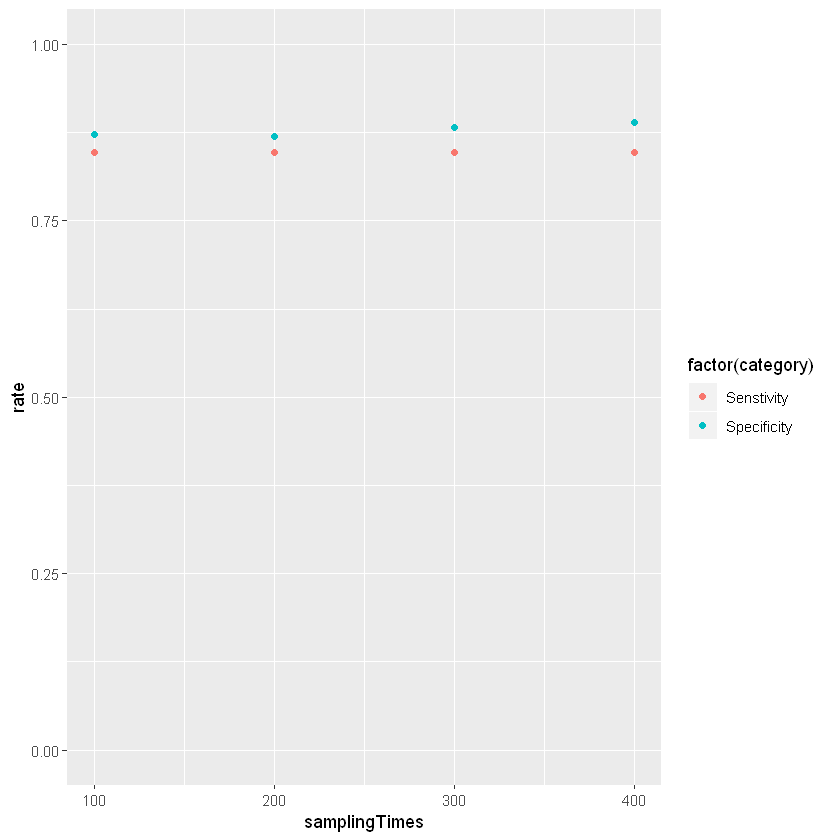

In [4]:
resultsDirPath <- file.path("Tests", "SamplingTimes")

predResult <- data.frame(
    "samplingTimes" = integer(),
    "rate" = double(),
    "category" = character()
)

for (mutFile in dir(resultsDirPath)) {
    mutations <- readRDS(file.path(resultsDirPath, mutFile))
    paths <- attr(mutations, "paths")
    nTip <- regmatches(mutFile, gregexpr("(?<=\\().*?(?=\\))", mutFile, perl=T))[[1]]
    
    assessTable <- siteCategory
    sites <- as.integer(names(mutations))
    assessTable[["predFixed"]] <- assessTable[["site"]] %in% sites
    x <- assessTable[["fixationSite"]] + assessTable[["predFixed"]]
    senstivity <- length(which(x == 2)) / nPositive
    specificity <- length(which(x == 0)) / nNegative
    predResult <- rbind(
        predResult,
        data.frame(
            "samplingTimes" = c(as.integer(nTip), as.integer(nTip)),
            "rate" = c(senstivity, specificity),
            "category" = c("Senstivity", "Specificity")
        )
    )
}
predResult <- predResult[order(predResult[["samplingTimes"]]), ]
row.names(predResult) <- NULL

p <- ggplot(predResult, aes(samplingTimes, rate)) +
    geom_point(aes(color = factor(category))) + ylim(0, 1)
p

## 2. Manually assess the results from `SamplingSize` Test

Save the visualized results in `Figures` folder and then manually assess each sites.

In [5]:
resultsDirPath <- file.path("Tests", "SamplingSize")

predResult <- data.frame(
    "samplingSize" = integer(),
    "rate" = double(),
    "category" = character()
)

totalTips <- length(attr(attr(mutations, "paths"), "tree")$tip.label)

for (mutFile in dir(resultsDirPath)) {
    mutations <- readRDS(file.path(resultsDirPath, mutFile))
    paths <- attr(mutations, "paths")
    nTip <- gsub("[\\(\\)]", "", regmatches(mutFile, gregexpr("\\(.*?\\)", mutFile))[[1]])
    
    assessTable <- siteCategory
    sites <- as.integer(names(mutations))
    assessTable[["predFixed"]] <- assessTable[["site"]] %in% sites
    x <- assessTable[["fixationSite"]] + assessTable[["predFixed"]]
    senstivity <- length(which(x == 2)) / nPositive
    specificity <- length(which(x == 0)) / nNegative
    predResult <- rbind(
        predResult,
        data.frame(
            "samplingSize" = c(as.integer(nTip), as.integer(nTip)) / totalTips,
            "rate" = c(senstivity, specificity),
            "category" = c("Senstivity", "Specificity")
        )
    )
}
predResult <- predResult[order(predResult[["samplingSize"]]), ]
row.names(predResult) <- NULL

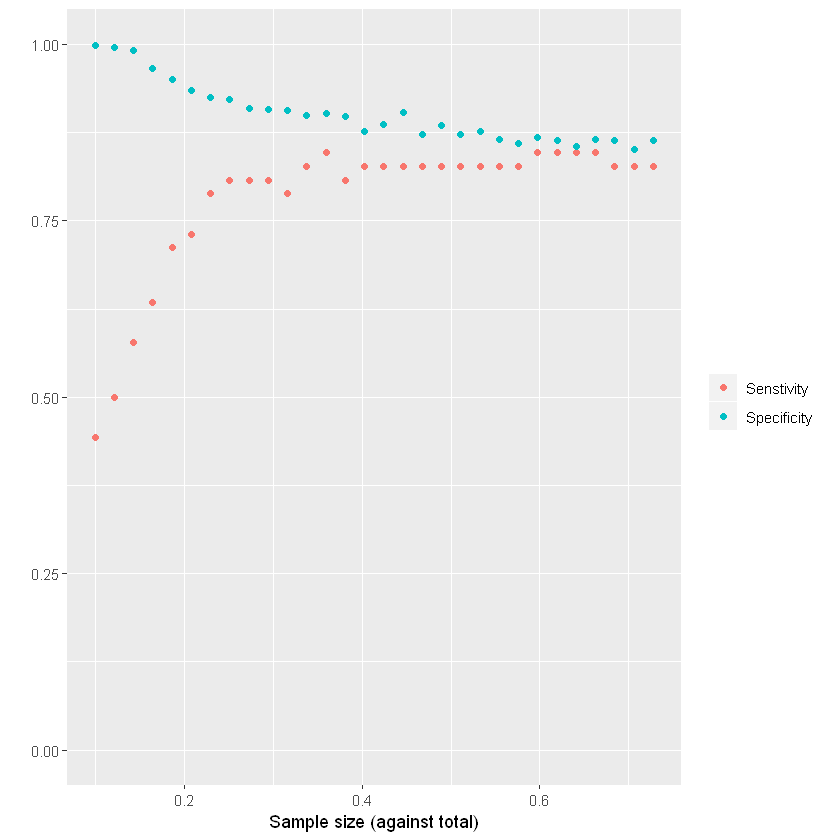

In [6]:
p <- ggplot(predResult, aes(samplingSize, rate)) +
    geom_point(aes(color = category)) + 
    ylim(0, 1) +
    labs(x = "Sample size (against total)", y = "", color = NULL)
p

ggsave(
    filename = file.path(figureDirPath, "samplingSize.pdf"),
    plot = p,
    device = "pdf",
    width = 3.25, height = 2
)

## 3. Manually assess the results from `minEffectiveSize` Test

Save the visualized results in `Figures` folder and then manually assess each sites.

In [7]:
resultsDirPath <- file.path("Tests", "minEffectiveSize")

predResult <- data.frame(
    "minEffectiveSize" = double(),
    "rate" = double(),
    "category" = character()
)

for (mutFile in dir(resultsDirPath)) {
    mutations <- readRDS(file.path(resultsDirPath, mutFile))
    paths <- attr(mutations, "paths")
    
    minEffectiveSize <- regmatches(mutFile, gregexpr("(?<=\\().*?(?=\\))", mutFile, perl=T))[[1]]
    minEffectiveSize <- ceiling(as.integer(minEffectiveSize))
    
    assessTable <- siteCategory
    sites <- as.integer(names(mutations))
    assessTable[["predFixed"]] <- assessTable[["site"]] %in% sites
    x <- assessTable[["fixationSite"]] + assessTable[["predFixed"]]
    senstivity <- length(which(x == 2)) / nPositive
    specificity <- length(which(x == 0)) / nNegative
    predResult <- rbind(
        predResult,
        data.frame(
            "minEffectiveSize" = c(minEffectiveSize, minEffectiveSize),
            "rate" = c(senstivity, specificity),
            "category" = c("Senstivity", "Specificity")
        )
    )
}

predResult <- predResult[order(predResult[["minEffectiveSize"]]), ]
row.names(predResult) <- NULL

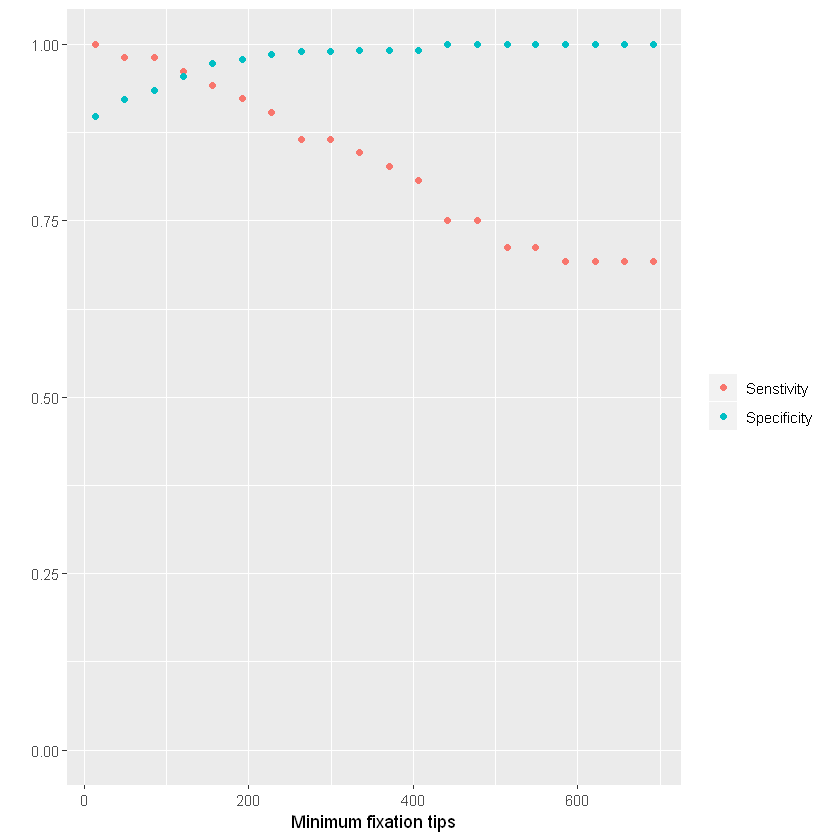

In [8]:
p <- ggplot(predResult, aes(minEffectiveSize, rate)) +
    geom_point(aes(color = category)) + 
    ylim(0, 1) +
    labs(x = "Minimum fixation tips", y = "", color = NULL)
p

ggsave(
    filename = file.path(figureDirPath, "minEffectiveSize.pdf"),
    plot = p,
    device = "pdf",
    width = 3.25, height = 2
)